# Problem 1 — One-Dimensional Bin Packing for E-commerce Fulfillment Using Ant Colony Optimization (ACO)


=== Running instance: u120_00  (n_items=120, capacity=150) ===
FFD baseline bins = 49
[Iter 10/200] iter-best bins=49, global-best bins=49, alpha=0.55, rho=0.289
[Iter 20/200] iter-best bins=49, global-best bins=49, alpha=0.60, rho=0.276
[Iter 30/200] iter-best bins=49, global-best bins=49, alpha=0.65, rho=0.264
[Iter 40/200] iter-best bins=49, global-best bins=49, alpha=0.70, rho=0.251
[Iter 50/200] iter-best bins=49, global-best bins=49, alpha=0.75, rho=0.238
[Iter 60/200] iter-best bins=49, global-best bins=49, alpha=0.80, rho=0.226
[Iter 70/200] iter-best bins=49, global-best bins=49, alpha=0.85, rho=0.213
[Iter 80/200] iter-best bins=49, global-best bins=49, alpha=0.90, rho=0.201
[Iter 90/200] iter-best bins=49, global-best bins=49, alpha=0.95, rho=0.188
[Iter 100/200] iter-best bins=49, global-best bins=49, alpha=1.00, rho=0.176
[Iter 110/200] iter-best bins=49, global-best bins=49, alpha=1.05, rho=0.163
[Iter 120/200] iter-best bins=49, global-best bins=49, alpha=1.10, rho=0.15

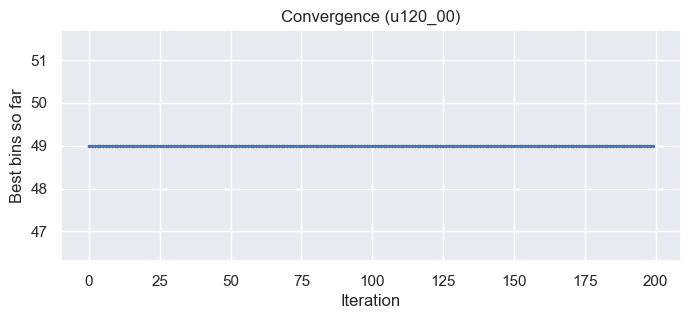

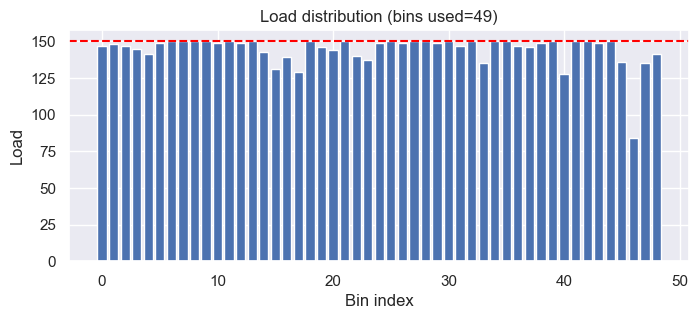


=== Running instance: u120_01  (n_items=120, capacity=150) ===
FFD baseline bins = 49
[Iter 10/200] iter-best bins=49, global-best bins=49, alpha=0.55, rho=0.289
[Iter 20/200] iter-best bins=49, global-best bins=49, alpha=0.60, rho=0.276
[Iter 30/200] iter-best bins=49, global-best bins=49, alpha=0.65, rho=0.264
[Iter 40/200] iter-best bins=49, global-best bins=49, alpha=0.70, rho=0.251
[Iter 50/200] iter-best bins=49, global-best bins=49, alpha=0.75, rho=0.238
[Iter 60/200] iter-best bins=49, global-best bins=49, alpha=0.80, rho=0.226
[Iter 70/200] iter-best bins=49, global-best bins=49, alpha=0.85, rho=0.213
[Iter 80/200] iter-best bins=49, global-best bins=49, alpha=0.90, rho=0.201
[Iter 90/200] iter-best bins=49, global-best bins=49, alpha=0.95, rho=0.188
[Iter 100/200] iter-best bins=49, global-best bins=49, alpha=1.00, rho=0.176
[Iter 110/200] iter-best bins=49, global-best bins=49, alpha=1.05, rho=0.163
[Iter 120/200] iter-best bins=49, global-best bins=49, alpha=1.10, rho=0.15

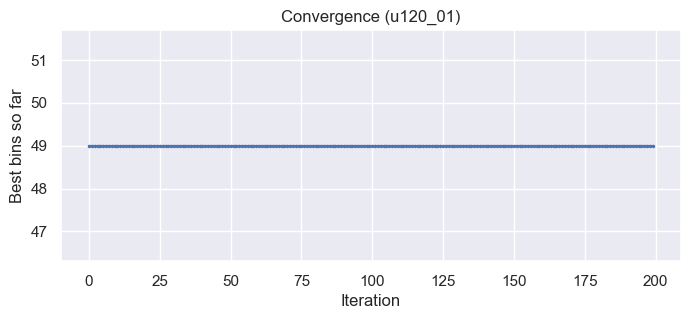

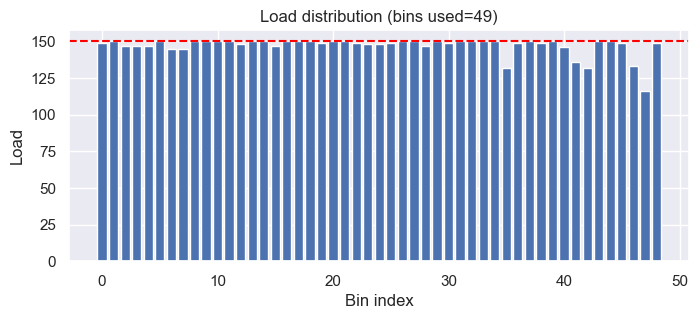


=== Running instance: u120_02  (n_items=120, capacity=150) ===
FFD baseline bins = 47
[Iter 10/200] iter-best bins=46, global-best bins=46, alpha=0.55, rho=0.289
[Iter 20/200] iter-best bins=46, global-best bins=46, alpha=0.60, rho=0.276
[Iter 30/200] iter-best bins=46, global-best bins=46, alpha=0.65, rho=0.264
[Iter 40/200] iter-best bins=46, global-best bins=46, alpha=0.70, rho=0.251
[Iter 50/200] iter-best bins=46, global-best bins=46, alpha=0.75, rho=0.238
[Iter 60/200] iter-best bins=46, global-best bins=46, alpha=0.80, rho=0.226
[Iter 70/200] iter-best bins=46, global-best bins=46, alpha=0.85, rho=0.213
[Iter 80/200] iter-best bins=46, global-best bins=46, alpha=0.90, rho=0.201
[Iter 90/200] iter-best bins=46, global-best bins=46, alpha=0.95, rho=0.188
[Iter 100/200] iter-best bins=46, global-best bins=46, alpha=1.00, rho=0.176
[Iter 110/200] iter-best bins=46, global-best bins=46, alpha=1.05, rho=0.163
[Iter 120/200] iter-best bins=46, global-best bins=46, alpha=1.10, rho=0.15

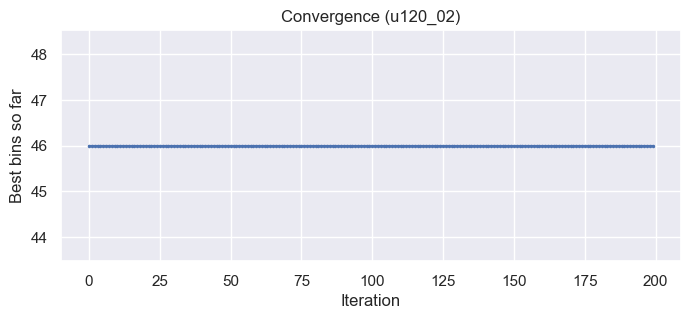

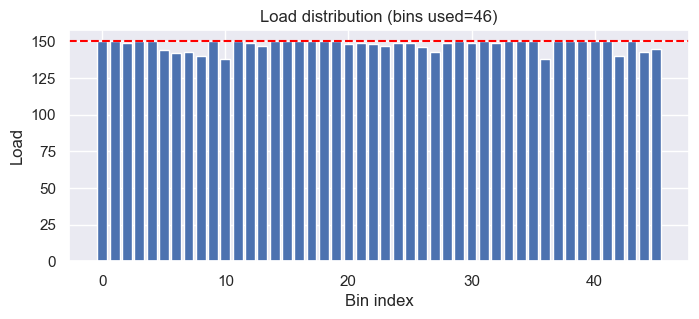

In [ ]:
# --- Imports & Small utilities ---
import math
import random
import time
from collections import defaultdict, Counter
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

# --- Config / Hyperparameters ---
CONFIG = {
    "alpha_start": 0.5,    # Start pheromone influence (lower = more exploration)
    "alpha_end": 1.5,      # End pheromone influence (higher = more exploitation)
    "beta": 2.0,           # heuristic influence (keep constant)
    "rho_start": 0.3,      # Start evaporation rate (higher = more exploration)
    "rho_end": 0.05,       # End evaporation rate (lower = more exploitation)
    "Q": 1.0,              # pheromone deposit factor (scaled by quality)
    "n_ants": 30,          # ants per iteration
    "iterations": 200,     # ACO iterations
    "seed": 42,
    "use_first_fit_decreasing_init": True,
    "max_bins_scale": 1.0,
    "print_every": 10,
    "verbose": True,
    "tau_min": 0.01,       # min initial pheromone to encourage exploration
}

random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

# --- Parser for OR-Library `binpack` files ---
def parse_orlib_binpack_file(text: str):
    tokens = text.split()
    idx = 0
    P = int(tokens[idx])
    idx += 1
    instances = []
    for _ in range(P):
        name = tokens[idx]
        idx += 1
        capacity = int(tokens[idx])
        idx += 1
        n_items = int(tokens[idx])
        idx += 1
        _best_known = tokens[idx]
        idx += 1
        items = []
        for i in range(n_items):
            items.append(int(tokens[idx]))
            idx += 1
        instances.append((name, capacity, items))
    return instances

# --- Baseline heuristic: First-Fit Decreasing (FFD) ---
def first_fit_decreasing(items: List[int], capacity: int) -> Tuple[int, List[List[int]]]:
    items_sorted = sorted(items, reverse=True)
    bins = []
    bin_caps = []
    for w in items_sorted:
        placed = False
        for i, rem in enumerate(bin_caps):
            if rem >= w:
                bins[i].append(w)
                bin_caps[i] -= w
                placed = True
                break
        if not placed:
            bins.append([w])
            bin_caps.append(capacity - w)
    return len(bins), bins

# --- ACOBinPacking class with adaptive parameters and better initialization ---
class ACOBinPacking:
    def __init__(self, items: List[int], capacity: int, config: dict):
        self.items = list(items)
        self.capacity = capacity
        self.n = len(items)
        self.config = config.copy()
        self.max_bins = max(1, int(self.n * max(1.0, config.get("max_bins_scale", 1.0))))
        self.item_order = sorted(range(self.n), key=lambda i: -self.items[i])
        tau_init = max(self.config.get("tau_min", 0.01), 0.01)
        self.tau = np.ones((self.n, self.max_bins)) * tau_init
        # parameters for adaptation during run
        self.alpha_start = self.config.get("alpha_start", 1.0)
        self.alpha_end = self.config.get("alpha_end", 1.0)
        self.beta = self.config.get("beta", 2.0)
        self.rho_start = self.config.get("rho_start", 0.1)
        self.rho_end = self.config.get("rho_end", 0.1)
        self.Q = self.config.get("Q", 1.0)

    def construct_solution(self, ant_seed=None):
        if ant_seed is not None:
            rand = random.Random(ant_seed)
        else:
            rand = random

        assignments = [-1] * self.n
        bins_loads = []
        bins_items = []

        for item_pos in self.item_order:
            w = self.items[item_pos]
            feasible_bins = []
            heuristics = []
            taus = []

            for b_idx, load in enumerate(bins_loads):
                rem = self.capacity - load
                if rem >= w:
                    remaining_after = rem - w
                    eta = 1.0 / (1.0 + remaining_after)
                    feasible_bins.append(b_idx)
                    heuristics.append(eta)
                    taus.append(self.tau[item_pos, b_idx])

            if len(bins_loads) < self.max_bins:
                remaining_after = self.capacity - w
                eta_new = 1.0 / (1.0 + remaining_after)
                new_slot_idx = len(bins_loads)
                feasible_bins.append(new_slot_idx)
                heuristics.append(eta_new)
                taus.append(self.tau[item_pos, new_slot_idx])

            if not feasible_bins:
                new_slot_idx = len(bins_loads)
                feasible_bins.append(new_slot_idx)
                heuristics.append(1.0 / (1.0 + (self.capacity - w)))
                taus.append(self.tau[item_pos, new_slot_idx] if new_slot_idx < self.max_bins else 0.1)

            tau_arr = np.array(taus) ** self.alpha
            eta_arr = np.array(heuristics) ** self.beta
            probs = tau_arr * eta_arr
            if probs.sum() == 0:
                probs = np.ones_like(probs)
            probs = probs / probs.sum()

            choice_idx = rand.choices(range(len(feasible_bins)), weights=probs, k=1)[0]
            chosen_bin = feasible_bins[choice_idx]

            if chosen_bin == len(bins_loads):
                bins_loads.append(w)
                bins_items.append([self.items[item_pos]])
            else:
                bins_loads[chosen_bin] += w
                bins_items[chosen_bin].append(self.items[item_pos])

            assignments[item_pos] = chosen_bin

        bins_used = len(bins_loads)
        total_unused = sum(self.capacity - load for load in bins_loads)
        return assignments, bins_items, bins_used, total_unused

    def local_repair_try_free_bin(self, bins_items: List[List[int]]) -> Tuple[List[List[int]], int]:
        bins = [list(b) for b in bins_items]
        loads = [sum(b) for b in bins]
        changed = True
        while changed:
            changed = False
            for i in range(len(bins)):
                if not bins[i]:
                    continue
                items_i = bins[i][:]
                can_move_all = True
                for w in items_i:
                    moved = False
                    for j in range(len(bins)):
                        if j == i:
                            continue
                        if sum(bins[j]) + w <= self.capacity:
                            bins[j].append(w)
                            bins[i].remove(w)
                            moved = True
                            break
                    if not moved:
                        can_move_all = False
                        break
                if can_move_all and len(bins[i]) == 0:
                    changed = True
                    bins.pop(i)
                    break
                else:
                    bins = [list(b) for b in bins_items]
                    break
        new_bins = [b for b in bins if b]
        return new_bins, len(new_bins)

    def run(self, n_ants: int, iterations: int, local_repair: bool=True, verbose: bool=False):
        best_solution = None
        best_history = []
        start_time = time.time()

        for it in range(1, iterations+1):
            # Adaptive alpha and rho (linear interpolation)
            self.alpha = self.alpha_start + (self.alpha_end - self.alpha_start) * (it - 1) / (iterations - 1)
            self.rho = self.rho_start + (self.rho_end - self.rho_start) * (it - 1) / (iterations - 1)

            ant_solutions = []
            for a in range(n_ants):
                seed = random.randint(0, 10**9)
                assign, bins_items, bins_used, total_unused = self.construct_solution(ant_seed=seed)
                if local_repair:
                    improved_bins, improved_used = self.local_repair_try_free_bin(bins_items)
                    if improved_used < bins_used:
                        bins_items = improved_bins
                        bins_used = improved_used
                        total_unused = sum(self.capacity - sum(b) for b in bins_items)
                ant_solutions.append((bins_used, total_unused, bins_items, assign))

            ant_solutions.sort(key=lambda x: (x[0], x[1]))
            best_ant = ant_solutions[0]
            b_used, b_unused, b_bins, b_assign = best_ant

            if (best_solution is None) or (b_used < best_solution[0]) or (b_used == best_solution[0] and b_unused < best_solution[1]):
                best_solution = (b_used, b_unused, b_bins, b_assign)

            best_history.append(best_solution[0])

            self.tau *= (1.0 - self.rho)

            for item_i, bin_j in enumerate(b_assign):
                if bin_j < self.max_bins:
                    self.tau[item_i, bin_j] += (self.Q / max(1, best_solution[0]))

            if verbose and (it % self.config.get("print_every", 10) == 0):
                print(f"[Iter {it}/{iterations}] iter-best bins={b_used}, global-best bins={best_solution[0]}, alpha={self.alpha:.2f}, rho={self.rho:.3f}")

        wall_time = time.time() - start_time
        return {
            "best_bins": best_solution[0],
            "best_unused": best_solution[1],
            "best_bins_items": best_solution[2],
            "best_assignments": best_solution[3],
            "history": best_history,
            "time_sec": wall_time
        }

# --- Experiment harness ---
def run_single_instance(name: str, items: List[int], capacity: int, config: dict):
    print(f"\n=== Running instance: {name}  (n_items={len(items)}, capacity={capacity}) ===")
    ffd_bins, ffd_bins_items = first_fit_decreasing(items, capacity)
    print(f"FFD baseline bins = {ffd_bins}")

    aco = ACOBinPacking(items, capacity, config)
    res = aco.run(n_ants=config["n_ants"], iterations=config["iterations"], local_repair=True, verbose=config.get("verbose", False))

    print(f"ACO best bins = {res['best_bins']}, unused capacity = {res['best_unused']}")
    print(f"Runtime = {res['time_sec']:.2f}s")

    plt.figure(figsize=(8,3))
    plt.plot(res["history"], marker=".", markersize=3)
    plt.xlabel("Iteration")
    plt.ylabel("Best bins so far")
    plt.title(f"Convergence ({name})")
    plt.show()

    bins_items = res["best_bins_items"]
    loads = [sum(b) for b in bins_items]
    plt.figure(figsize=(8,3))
    plt.bar(range(len(loads)), loads)
    plt.axhline(capacity, color='red', linestyle='--')
    plt.xlabel("Bin index")
    plt.ylabel("Load")
    plt.title(f"Load distribution (bins used={res['best_bins']})")
    plt.show()

    return res

# --- MAIN RUN ---
if __name__ == "__main__":
    filename = "Binpacks/binpack1.txt"  # adjust if needed
    with open(filename, "r") as f:
        text = f.read()

    instances = parse_orlib_binpack_file(text)

    # Run on the first 3 problems in the file
    for name, capacity, items in instances[:3]:
        run_single_instance(name, items, capacity, CONFIG)

# Problem 2 — Optimize Classic Benchmark Functions using Particle Swarm Optimization (PSO)

In [ ]:
# --- Imports ---
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable, Tuple, List
import time

# Configure matplotlib for notebook display
plt.rcParams['figure.max_open_warning'] = 0  # Suppress warning about too many open figures

print("Starting Problem 2 - PSO Optimization...")
print("Loading libraries...")

sns.set(style="darkgrid")

print("Libraries loaded successfully!")

# --- Configuration ---
CONFIG = {
    "n_particles": 30,        # Number of particles in swarm
    "n_dimensions": 2,         # Number of dimensions (can be 2, 10, 30, etc.)
    "max_iterations": 1000,    # Maximum iterations
    "w": 0.7,                 # Inertia weight
    "c1": 1.5,                # Cognitive coefficient
    "c2": 1.5,                # Social coefficient
    "seed": 42,
    "print_every": 100,
    "verbose": True,
}

np.random.seed(CONFIG["seed"])

# --- Benchmark Functions ---

def sphere(x: np.ndarray) -> float:
    """
    Sphere function: f(x) = sum(x_i^2)
    Global minimum: f(0, 0, ..., 0) = 0
    Search range: typically [-5.12, 5.12]
    """
    return np.sum(x**2)

def rosenbrock(x: np.ndarray) -> float:
    """
    Rosenbrock function (banana function)
    Global minimum: f(1, 1, ..., 1) = 0
    Search range: typically [-2.048, 2.048]
    """
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def rastrigin(x: np.ndarray) -> float:
    """
    Rastrigin function
    Global minimum: f(0, 0, ..., 0) = 0
    Search range: typically [-5.12, 5.12]
    """
    A = 10
    n = len(x)
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def ackley(x: np.ndarray) -> float:
    """
    Ackley function
    Global minimum: f(0, 0, ..., 0) = 0
    Search range: typically [-32, 32]
    """
    a = 20
    b = 0.2
    c = 2 * np.pi
    n = len(x)
    sum1 = np.sum(x**2)
    sum2 = np.sum(np.cos(c * x))
    return -a * np.exp(-b * np.sqrt(sum1 / n)) - np.exp(sum2 / n) + a + np.e

def griewank(x: np.ndarray) -> float:
    """
    Griewank function
    Global minimum: f(0, 0, ..., 0) = 0
    Search range: typically [-600, 600]
    """
    sum_sq = np.sum(x**2)
    prod = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
    return 1 + sum_sq / 4000 - prod

def schwefel(x: np.ndarray) -> float:
    """
    Schwefel function
    Global minimum: f(420.9687, ..., 420.9687) ≈ 0
    Search range: typically [-500, 500]
    """
    n = len(x)
    return 418.9829 * n - np.sum(x * np.sin(np.sqrt(np.abs(x))))

# Function definitions with bounds
BENCHMARK_FUNCTIONS = {
    "Sphere": {
        "func": sphere,
        "bounds": (-5.12, 5.12),
        "global_min": 0.0,
        "global_min_pos": np.zeros(CONFIG["n_dimensions"])
    },
    "Rosenbrock": {
        "func": rosenbrock,
        "bounds": (-2.048, 2.048),
        "global_min": 0.0,
        "global_min_pos": np.ones(CONFIG["n_dimensions"])
    },
    "Rastrigin": {
        "func": rastrigin,
        "bounds": (-5.12, 5.12),
        "global_min": 0.0,
        "global_min_pos": np.zeros(CONFIG["n_dimensions"])
    },
    "Ackley": {
        "func": ackley,
        "bounds": (-32, 32),
        "global_min": 0.0,
        "global_min_pos": np.zeros(CONFIG["n_dimensions"])
    },
    "Griewank": {
        "func": griewank,
        "bounds": (-600, 600),
        "global_min": 0.0,
        "global_min_pos": np.zeros(CONFIG["n_dimensions"])
    },
    "Schwefel": {
        "func": schwefel,
        "bounds": (-500, 500),
        "global_min": 0.0,
        "global_min_pos": np.full(CONFIG["n_dimensions"], 420.9687)
    }
}

# --- Particle Swarm Optimization Class ---
class ParticleSwarmOptimizer:
    def __init__(self, objective_func: Callable, bounds: Tuple[float, float],
                 n_particles: int, n_dimensions: int, w: float, c1: float, c2: float):
        self.objective_func = objective_func
        self.bounds = bounds
        self.n_particles = n_particles
        self.n_dimensions = n_dimensions
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive coefficient
        self.c2 = c2  # Social coefficient
        
        # Initialize particles
        self.positions = np.random.uniform(
            bounds[0], bounds[1], (n_particles, n_dimensions)
        )
        self.velocities = np.random.uniform(
            -abs(bounds[1] - bounds[0]), abs(bounds[1] - bounds[0]),
            (n_particles, n_dimensions)
        )
        
        # Initialize personal bests
        self.personal_best_positions = self.positions.copy()
        self.personal_best_values = np.array([
            objective_func(pos) for pos in self.positions
        ])
        
        # Initialize global best
        self.global_best_idx = np.argmin(self.personal_best_values)
        self.global_best_position = self.personal_best_positions[self.global_best_idx].copy()
        self.global_best_value = self.personal_best_values[self.global_best_idx]
        
        # History for tracking
        self.history = [self.global_best_value]
    
    def update_velocities(self):
        """Update particle velocities"""
        r1 = np.random.rand(self.n_particles, self.n_dimensions)
        r2 = np.random.rand(self.n_particles, self.n_dimensions)
        
        cognitive = self.c1 * r1 * (self.personal_best_positions - self.positions)
        social = self.c2 * r2 * (self.global_best_position - self.positions)
        
        self.velocities = (self.w * self.velocities + cognitive + social)
    
    def update_positions(self):
        """Update particle positions"""
        self.positions += self.velocities
        
        # Apply bounds (clamp positions)
        self.positions = np.clip(self.positions, self.bounds[0], self.bounds[1])
    
    def update_bests(self):
        """Update personal and global bests"""
        # Evaluate current positions
        current_values = np.array([
            self.objective_func(pos) for pos in self.positions
        ])
        
        # Update personal bests
        improved = current_values < self.personal_best_values
        self.personal_best_positions[improved] = self.positions[improved].copy()
        self.personal_best_values[improved] = current_values[improved]
        
        # Update global best
        best_idx = np.argmin(self.personal_best_values)
        if self.personal_best_values[best_idx] < self.global_best_value:
            self.global_best_value = self.personal_best_values[best_idx]
            self.global_best_position = self.personal_best_positions[best_idx].copy()
            self.global_best_idx = best_idx
    
    def optimize(self, max_iterations: int, verbose: bool = False, print_every: int = 100):
        """Run PSO optimization"""
        start_time = time.time()
        
        for iteration in range(max_iterations):
            self.update_velocities()
            self.update_positions()
            self.update_bests()
            self.history.append(self.global_best_value)
            
            if verbose and (iteration + 1) % print_every == 0:
                print(f"Iteration {iteration + 1}/{max_iterations}: "
                      f"Best value = {self.global_best_value:.6e}, "
                      f"Position = {self.global_best_position}")
        
        elapsed_time = time.time() - start_time
        
        return {
            "best_position": self.global_best_position,
            "best_value": self.global_best_value,
            "history": self.history,
            "time_sec": elapsed_time
        }

# --- Visualization Functions ---
def plot_convergence(history: List[float], function_name: str, ax=None):
    """Plot convergence history"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(history, linewidth=2)
    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_ylabel("Best Value", fontsize=12)
    ax.set_title(f"PSO Convergence: {function_name}", fontsize=14, fontweight="bold")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    return ax

def plot_2d_contour(function_name: str, function_info: dict, result: dict, ax=None):
    """Plot 2D contour plot with particle positions (for 2D functions only)"""
    if CONFIG["n_dimensions"] != 2:
        return None
    
    func = function_info["func"]
    bounds = function_info["bounds"]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create meshgrid
    x = np.linspace(bounds[0], bounds[1], 100)
    y = np.linspace(bounds[0], bounds[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    
    # Plot contour
    contour = ax.contour(X, Y, Z, levels=50, alpha=0.6)
    ax.clabel(contour, inline=True, fontsize=8)
    ax.contourf(X, Y, Z, levels=50, alpha=0.3, cmap="viridis")
    
    # Mark global minimum
    global_min_pos = function_info["global_min_pos"]
    ax.plot(global_min_pos[0], global_min_pos[1], "r*", 
            markersize=20, label="Global Minimum", zorder=5)
    
    # Mark found solution
    best_pos = result["best_position"]
    ax.plot(best_pos[0], best_pos[1], "go", 
            markersize=15, label="PSO Solution", zorder=5)
    
    ax.set_xlabel("x1", fontsize=12)
    ax.set_ylabel("x2", fontsize=12)
    ax.set_title(f"2D Contour: {function_name}", 
                 fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

# --- Run Optimization on Benchmark Functions ---
def run_benchmark(function_name: str, function_info: dict, config: dict):
    """Run PSO on a single benchmark function"""
    print(f"\n{'='*60}")
    print(f"Optimizing: {function_name}")
    print(f"Dimensions: {config['n_dimensions']}")
    print(f"Particles: {config['n_particles']}")
    print(f"Bounds: {function_info['bounds']}")
    print(f"Global minimum: {function_info['global_min']}")
    print(f"{'='*60}")
    
    # Create optimizer
    pso = ParticleSwarmOptimizer(
        objective_func=function_info["func"],
        bounds=function_info["bounds"],
        n_particles=config["n_particles"],
        n_dimensions=config["n_dimensions"],
        w=config["w"],
        c1=config["c1"],
        c2=config["c2"]
    )
    
    # Run optimization
    result = pso.optimize(
        max_iterations=config["max_iterations"],
        verbose=config.get("verbose", False),
        print_every=config.get("print_every", 100)
    )
    
    # Print results
    print(f"\nResults:")
    print(f"  Best value found: {result['best_value']:.6e}")
    print(f"  Global minimum: {function_info['global_min']:.6e}")
    print(f"  Error: {abs(result['best_value'] - function_info['global_min']):.6e}")
    print(f"  Best position: {result['best_position']}")
    print(f"  Runtime: {result['time_sec']:.2f} seconds")
    
    # Plot convergence
    plt.figure(figsize=(10, 6))
    plot_convergence(result["history"], function_name)
    plt.tight_layout()
    plt.show()
    
    # Plot 2D contour if applicable
    if config["n_dimensions"] == 2:
        plt.figure(figsize=(10, 8))
        plot_2d_contour(function_name, function_info, result)
        plt.tight_layout()
        plt.show()
    
    return result

# --- Main Execution ---
print("\n" + "="*80)
print("BEGINNING PSO OPTIMIZATION ON ALL BENCHMARK FUNCTIONS")
print("="*80)
print(f"Configuration: {CONFIG['n_particles']} particles, {CONFIG['n_dimensions']}D, {CONFIG['max_iterations']} iterations")
print("="*80 + "\n")

# Run on all benchmark functions
results = {}

for func_name, func_info in BENCHMARK_FUNCTIONS.items():
    result = run_benchmark(func_name, func_info, CONFIG)
    results[func_name] = result

# Summary table
print(f"\n{'='*80}")
print("SUMMARY OF RESULTS")
print(f"{'='*80}")
print(f"{'Function':<15} {'Best Value':<20} {'Error':<20} {'Time (s)':<10}")
print("-" * 80)

for func_name, result in results.items():
    func_info = BENCHMARK_FUNCTIONS[func_name]
    error = abs(result["best_value"] - func_info["global_min"])
    print(f"{func_name:<15} {result['best_value']:<20.6e} {error:<20.6e} {result['time_sec']:<10.2f}")

print(f"{'='*80}")

# ============================================================================
# IMPORTANT VISUALIZATIONS - Displayed at the bottom
# ============================================================================

print("\n" + "="*80)
print("GENERATING FINAL VISUALIZATIONS")
print("="*80)

# --- 1. Combined Convergence Plot (Most Important) ---
print("\n[1/3] Combined Convergence Plot - All Functions")
plt.figure(figsize=(14, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
for idx, (func_name, result) in enumerate(results.items()):
    plt.plot(result["history"], label=func_name, linewidth=2.5, alpha=0.8, color=colors[idx])

plt.xlabel("Iteration", fontsize=13, fontweight="bold")
plt.ylabel("Best Value (log scale)", fontsize=13, fontweight="bold")
plt.title("PSO Convergence Comparison - All Benchmark Functions", fontsize=16, fontweight="bold", pad=20)
plt.yscale("log")
plt.legend(loc="upper right", fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
plt.close()  # Close to free memory

# --- 2. Performance Comparison Charts ---
print("\n[2/3] Performance Comparison Charts")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

func_names = list(results.keys())
errors = [abs(results[f]["best_value"] - BENCHMARK_FUNCTIONS[f]["global_min"]) 
          for f in func_names]
times = [results[f]["time_sec"] for f in func_names]

# Error comparison
bars1 = axes[0].bar(func_names, errors, color='steelblue', alpha=0.8, edgecolor='navy', linewidth=1.5)
axes[0].set_ylabel("Error (Distance from Global Minimum)", fontsize=12, fontweight="bold")
axes[0].set_title("Optimization Error by Function", fontsize=14, fontweight="bold", pad=15)
axes[0].set_yscale("log")
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')
# Add value labels on bars
for bar, error in zip(bars1, errors):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{error:.2e}', ha='center', va='bottom', fontsize=8, rotation=90)

# Runtime comparison
bars2 = axes[1].bar(func_names, times, color='coral', alpha=0.8, edgecolor='darkred', linewidth=1.5)
axes[1].set_ylabel("Runtime (seconds)", fontsize=12, fontweight="bold")
axes[1].set_title("Runtime by Function", fontsize=14, fontweight="bold", pad=15)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')
# Add value labels on bars
for bar, time_val in zip(bars2, times):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.2f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
plt.close(fig)  # Close to free memory

# --- 3. 2D Contour Plots for Each Function (if 2D) ---
if CONFIG["n_dimensions"] == 2:
    print("\n[3/3] 2D Contour Plots - Function Landscapes")
    n_funcs = len(results)
    cols = 3
    rows = (n_funcs + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    axes_flat = axes.flatten()
    
    for idx, (func_name, result) in enumerate(results.items()):
        ax = axes_flat[idx]
        func_info = BENCHMARK_FUNCTIONS[func_name]
        
        # Create meshgrid
        bounds = func_info["bounds"]
        x = np.linspace(bounds[0], bounds[1], 100)
        y = np.linspace(bounds[0], bounds[1], 100)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = func_info["func"](np.array([X[i, j], Y[i, j]]))
        
        # Plot contour
        contour = ax.contour(X, Y, Z, levels=20, alpha=0.6, linewidths=1)
        ax.contourf(X, Y, Z, levels=20, alpha=0.4, cmap="viridis")
        
        # Mark global minimum
        global_min_pos = func_info["global_min_pos"]
        ax.plot(global_min_pos[0], global_min_pos[1], "r*", 
                markersize=20, label="Global Min", zorder=5, markeredgecolor='white', markeredgewidth=2)
        
        # Mark found solution
        best_pos = result["best_position"]
        ax.plot(best_pos[0], best_pos[1], "go", 
                markersize=12, label="PSO Solution", zorder=5, markeredgecolor='white', markeredgewidth=2)
        
        ax.set_xlabel("x1", fontsize=11, fontweight="bold")
        ax.set_ylabel("x2", fontsize=11, fontweight="bold")
        ax.set_title(f"{func_name}", fontsize=13, fontweight="bold", pad=10)
        ax.legend(loc="upper right", fontsize=9)
        ax.grid(True, alpha=0.2)
    
    # Hide unused subplots
    for idx in range(len(results), len(axes_flat)):
        axes_flat[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close to free memory
else:
    print("\n[3/3] Skipping 2D contour plots (dimensions != 2)")

print("\n" + "="*80)
print("Problem 2 - PSO Optimization Complete!")
print("="*80)


# Problem 3 — Solving 0–1 Knapsack Problem Using Bees Algorithm (BA)

# Problem 5 — Q-learning on FrozenLake

Environment: 4x4 | States: 16, Actions: 4
Using algorithm: Q-learning (off-policy)
Ep 500/20000 | Last500 avg: 0.036 | Eps: 0.779 | MaxQ: 0.94
Ep 1000/20000 | Last500 avg: 0.064 | Eps: 0.606 | MaxQ: 0.98
Ep 1500/20000 | Last500 avg: 0.098 | Eps: 0.472 | MaxQ: 0.97
Ep 2000/20000 | Last500 avg: 0.208 | Eps: 0.368 | MaxQ: 1.00
Ep 2500/20000 | Last500 avg: 0.304 | Eps: 0.286 | MaxQ: 0.99
Ep 3000/20000 | Last500 avg: 0.428 | Eps: 0.223 | MaxQ: 0.95
Ep 3500/20000 | Last500 avg: 0.502 | Eps: 0.174 | MaxQ: 0.99
Ep 4000/20000 | Last500 avg: 0.584 | Eps: 0.135 | MaxQ: 0.98
Ep 4500/20000 | Last500 avg: 0.626 | Eps: 0.105 | MaxQ: 0.97
Ep 5000/20000 | Last500 avg: 0.712 | Eps: 0.082 | MaxQ: 1.00
Ep 5500/20000 | Last500 avg: 0.794 | Eps: 0.064 | MaxQ: 0.99
Ep 6000/20000 | Last500 avg: 0.844 | Eps: 0.050 | MaxQ: 1.00
Ep 6500/20000 | Last500 avg: 0.858 | Eps: 0.039 | MaxQ: 0.86
Ep 7000/20000 | Last500 avg: 0.874 | Eps: 0.030 | MaxQ: 1.00
Ep 7500/20000 | Last500 avg: 0.918 | Eps: 0.023 | MaxQ: 1.00
Ep 

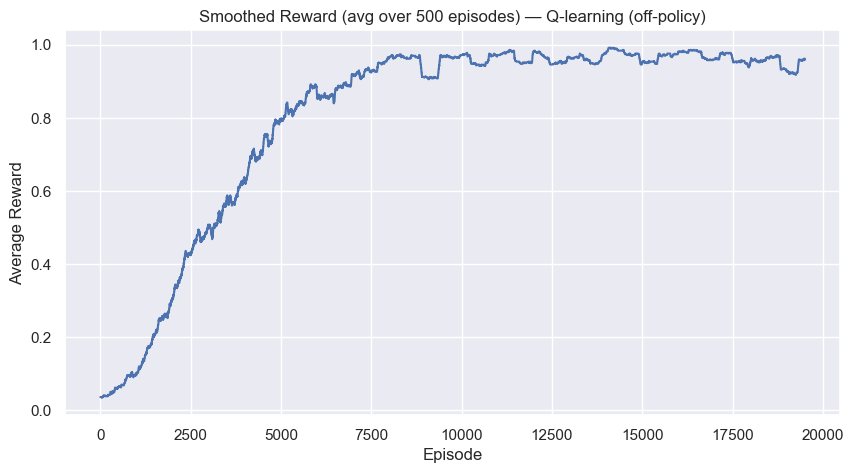

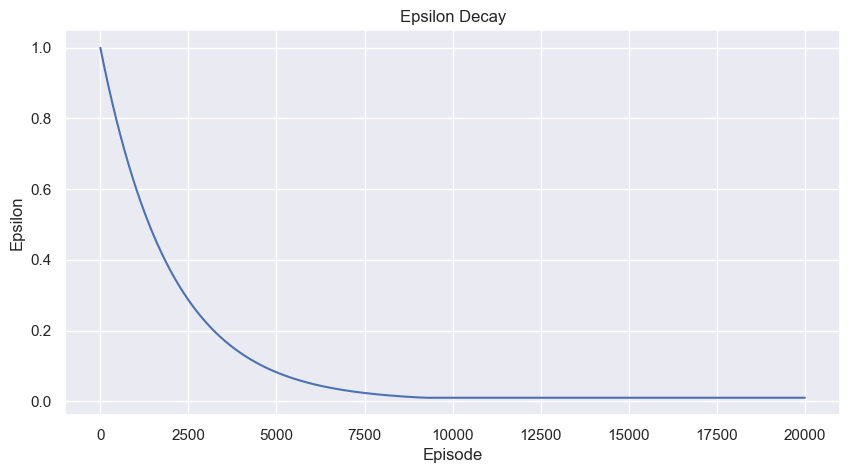

In [ ]:
# --- Imports ---
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
CONFIG = {
    'env_name': 'FrozenLake-v1',
    'map_name': '4x4',             # '4x4' → Q-learning, '8x8' → SARSA
    'is_slippery': True,           # Keep True for challenge
    'alpha': 0.3,                  # Learning rate
    'gamma': 0.99,                 # Discount factor
    'epsilon': 1.0,                # Starting exploration rate
    'epsilon_min': 0.01,
    'epsilon_decay': 0.9995,       # slower decay for large maps
    'episodes': 20000,             # more episodes for 8x8
    'max_steps': 200,              # allow more steps per episode
    'seed': 42
}

# --- Set seeds ---
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# --- Initialize environment ---
env = gym.make(CONFIG['env_name'], map_name=CONFIG['map_name'], is_slippery=CONFIG['is_slippery'])
env.reset(seed=CONFIG['seed'])
n_states = env.observation_space.n
n_actions = env.action_space.n
print(f"Environment: {CONFIG['map_name']} | States: {n_states}, Actions: {n_actions}")

# --- Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.Q = np.zeros((n_states, n_actions))

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.Q[state])

    def update(self, s, a, r, s_next, done):
        best_next = np.max(self.Q[s_next])
        target = r + (0 if done else self.gamma * best_next)
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# --- SARSA Agent (on-policy) ---
class SARSAAgent(QLearningAgent):
    def update(self, s, a, r, s_next, done, a_next):
        target = r + (0 if done else self.gamma * self.Q[s_next, a_next])
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

# --- Select algorithm ---
if CONFIG['map_name'] == '8x8':
    agent = SARSAAgent(n_states, n_actions,
                       CONFIG['alpha'], CONFIG['gamma'],
                       CONFIG['epsilon'], CONFIG['epsilon_min'],
                       CONFIG['epsilon_decay'])
    algo_name = "SARSA (on-policy)"
else:
    agent = QLearningAgent(n_states, n_actions,
                           CONFIG['alpha'], CONFIG['gamma'],
                           CONFIG['epsilon'], CONFIG['epsilon_min'],
                           CONFIG['epsilon_decay'])
    algo_name = "Q-learning (off-policy)"

print(f"Using algorithm: {algo_name}")

# --- Training Loop ---
rewards_per_episode = []
epsilons = []

for episode in range(CONFIG['episodes']):
    state, _ = env.reset(seed=CONFIG['seed'])
    total_reward = 0

    # choose first action (SARSA needs it)
    action = agent.choose_action(state)

    for step in range(CONFIG['max_steps']):
        next_state, reward, done, truncated, _ = env.step(action)

        # Reward shaping (helps learning in 8x8)
        if CONFIG['map_name'] == '8x8' and reward == 0 and not done:
            reward = -0.01

        if isinstance(agent, SARSAAgent):
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, next_state, done, next_action)
            action = next_action
        else:
            agent.update(state, action, reward, next_state, done)
            action = agent.choose_action(next_state)

        state = next_state
        total_reward += reward
        if done or truncated:
            break

    agent.decay_epsilon()
    rewards_per_episode.append(total_reward)
    epsilons.append(agent.epsilon)

    # --- Live feedback ---
    if (episode + 1) % 500 == 0:
        avg = np.mean(rewards_per_episode[-500:])
        print(f"Ep {episode + 1}/{CONFIG['episodes']} | "
              f"Last500 avg: {avg:.3f} | "
              f"Eps: {agent.epsilon:.3f} | MaxQ: {agent.Q.max():.2f}")

print("\nTraining completed ✅")

# --- Evaluation (greedy policy) ---
n_eval_episodes = 200
successes = 0
steps_list = []

for _ in range(n_eval_episodes):
    state, _ = env.reset(seed=CONFIG['seed'])
    for step in range(CONFIG['max_steps']):
        action = np.argmax(agent.Q[state])
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        if done or truncated:
            if reward > 0:
                successes += 1
            steps_list.append(step + 1)
            break

success_rate = successes / n_eval_episodes
print(f"Evaluation over {n_eval_episodes} episodes ({algo_name}):")
print(f"  Success rate: {success_rate*100:.1f}%")
print(f"  Avg steps (successful episodes): {np.mean(steps_list) if steps_list else 0:.2f}")

# --- Inspect learned Q-values ---
print("\nSample Q-values (first 10 states):")
print(agent.Q[:10])

# --- Plot learning progress ---
sns.set(style="darkgrid")
window = 500
smoothed_rewards = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards)
plt.title(f"Smoothed Reward (avg over {window} episodes) — {algo_name}")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epsilons)
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()